# Introduction to Gradient Boosting

## Prerequisites

* Preliminaries:
    * Regression & Classification
    * Decision Trees & Forests
    * Logistic Regression
    * Differential Calculus


* For Scorecard Extension:
    * Logistic Regression
    * One-Hot Encoding

## Learning Goals

By the end of this lecture a student should be able to:

* Explain why gradient boosted trees are more prone to overfitting than forests.
* Explain why gradient boosting is still relatively robust to overfitting and what some of the nuances may be.
* Explain why we use early stopping criteria and reduced learning rates.
* Create a gradient boosted classifier using:
    * Scikit-Learn
    * XGBoost
    * LightGBM
    * etc.

Above and Beyond:

* Explain how to create a decision tree proxy (surrogate model) of a "black-box" model and its potential benefits and downsides.

## Imports

In [4]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 2.6 MB/s eta 0:00:01


In [5]:
!pip install xgboost

     |████████████████████████████████| 1.1 MB 2.7 MB/s eta 0:00:01


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'mlxtend'

## Template

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


# for reference
class TemplateClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]

## Helper Functions

In [ ]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(self.forest.apply(X))

    
# TO-DO
class SurrogateClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model, proxy_model, base_size, test_size, random_state=0):
        self.base_model = base_model
        self.proxy_model = proxy_model
        self.base_size = base_size
        self.test_size = test_size
        self.proxy_size = 1 - base_size - test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        pass
    
    def predict_proba(self, X):
        pass
        

# Examples

## Too Many Dimensions to Visualize (X: 10-dimensions)

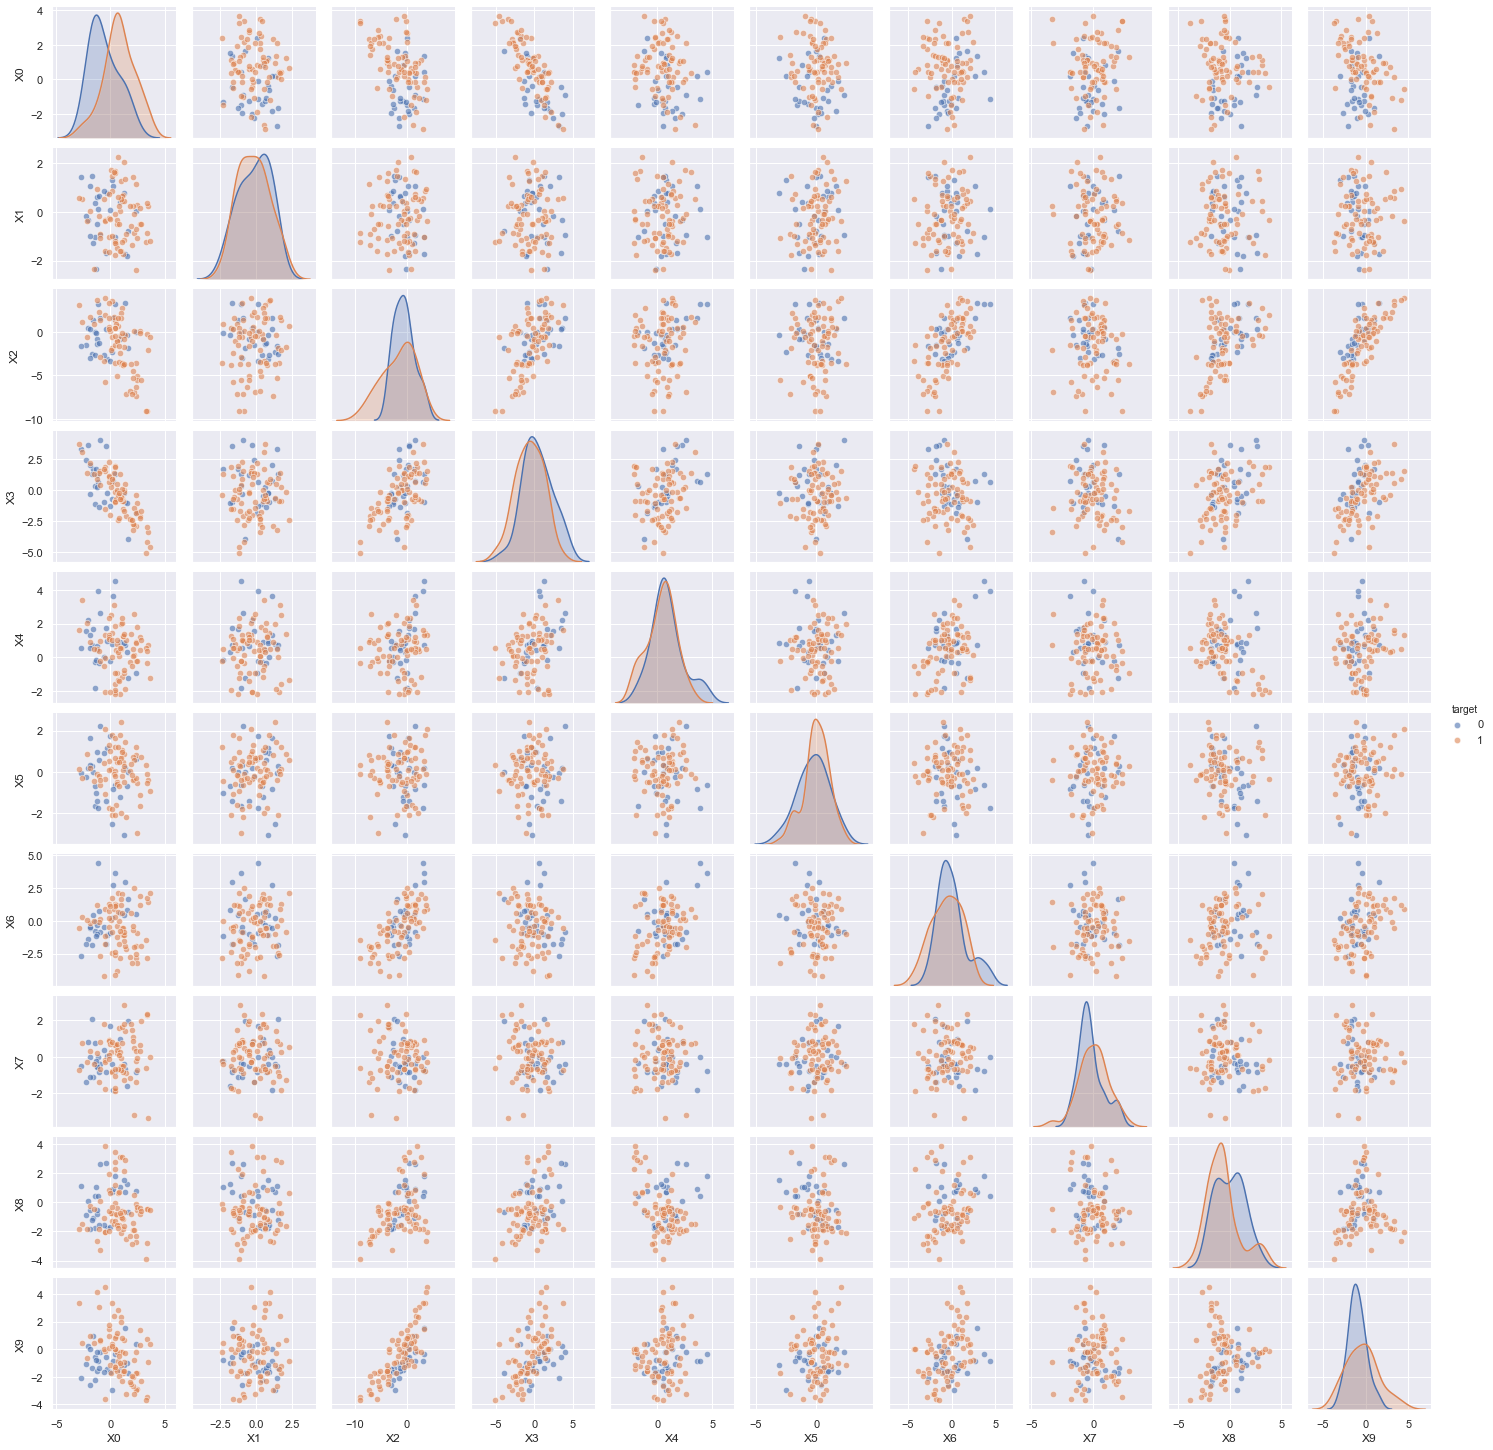

In [2]:
X, y = make_classification(n_samples=1000, 
                           n_features=10, n_informative=5, n_redundant=2, 
                           n_classes=2, n_clusters_per_class=3, 
                           weights=[0.3], random_state=42)


cols = ["X"+str(i) for i in range(10)]
df_10 = pd.DataFrame(X, columns=cols)
target = 'target'
df_10[target] = y

samp = df_10.sample(100)

sns.pairplot(samp, vars=cols, 
             hue=target, diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 40},
             height=2)
plt.show()

## Tuned Forest-Scorecard Baseline

In [3]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                            criterion='entropy', max_depth=10, max_features=5,
                            min_samples_leaf=3, min_samples_split=5,
                            n_estimators=71, n_jobs=-1, random_state=42)

encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

NameError: name 'RandomForestClassifier' is not defined

# Gradient Boosting

## Gradient Boosting with SciKit-Learn

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC

### Simple Model Baselines

#### Support Vector Machine

In [ ]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

svm = SVC(probability=True, class_weight='balanced', random_state=42)

scores = cross_val_score(svm, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

#### Random Forest

In [ ]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

### Boosted Models

#### AdaBoosted SVM

In [ ]:
clf = AdaBoostClassifier(svm, n_estimators=50, 
                         learning_rate=0.1, random_state=42)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

#### Gradient Boosted Trees

In [ ]:
clf = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.1, random_state=42, 
                                 subsample=0.9, max_depth=5, max_features=5,
                                 min_samples_leaf=2, min_samples_split=5,
                                 validation_fraction=0.20, # use 20% of the data as hold-out for early stopping
                                 n_iter_no_change=50, # allowed to go 50 iterations without improvement to hold-out score
                                 verbose=0)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

In [ ]:
# clf.fit(X, y)
# clf.feature_importances_

**Note**: We will need to tune this to beat the performance of the tuned forest.

#### Histogram-Gradient Boosted Trees (akin to the LightGBM algorithm)

In [ ]:
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', random_state=42, 
                                     learning_rate=0.05, max_iter=150, 
                                     max_leaf_nodes=2**5-1, max_bins=100, l2_regularization=0.5)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

#### NGBoost

In [ ]:
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE

In [ ]:
ngb = NGBClassifier(Base=default_tree_learner, 
                    Dist=Bernoulli, 
                    Score=MLE, verbose=False)

scores = cross_val_score(ngb, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

In [ ]:
ngb

**Note**: We need to tune the default hyper-parameters to improve upon this score.

# Surrogate Modeling

We can take a "black-box" model such as a GBM and make it more interpretable by approximating with a simpler model like a DT.

## Original Model and Setup

In [ ]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

# original model
clf = AdaBoostClassifier(svm, n_estimators=50, 
                         learning_rate=0.1, 
                         random_state=42)

# 45 - 45 - 10 Split : Train - Proxy - Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_proxy, y_train, y_proxy = train_test_split(X_train, y_train, test_size=0.50, 
                                                      random_state=42, 
                                                      stratify=y_train)

# fit the original model
clf.fit(X_train, y_train)

# score on hold-out set
y_pred = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

## Surrogate Model

In [ ]:
# predicted probabilities on the "proxy" hold-out set
y_pred = clf.predict_proba(X_proxy)[:,1]

# surrogate / proxy - DT approximation of Original model
dt = DecisionTreeRegressor(max_leaf_nodes=2**4-1, random_state=42)
dt.fit(X_proxy, y_pred)

In [ ]:
y_pred = dt.predict(X_test)
roc_auc_score(y_test, y_pred)

## Visualizing the Surrogate Model

In [ ]:
from sklearn.tree import plot_tree
plot_tree(dt, feature_names=used_cols, filled=True,
          leaves_parallel=True, node_ids=True, rotate=True)

# References / Resources

* SciKit-Learn Implementations

    * https://scikit-learn.org/stable/modules/ensemble.html#adaboost

    * https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting

    * https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

* Non-SciKit-Learn Implementations

    * https://github.com/catboost/catboost

    * https://github.com/microsoft/LightGBM

    * https://github.com/jhwjhw0123/Imbalance-XGBoost

    * https://github.com/dmlc/xgboost

    * https://github.com/stanfordmlgroup/ngboost

* Background

    * https://en.wikipedia.org/wiki/Gradient_boosting

    * https://explained.ai/gradient-boosting/index.html

    * https://en.wikipedia.org/wiki/AdaBoost

    * https://en.wikipedia.org/wiki/XGBoost

* Other

    * https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

    * https://github.com/szilard/GBM-perf

    * https://github.com/talperetz/awesome-gradient-boosting#notebooks

    * https://nbviewer.jupyter.org/github/jphall663/interpretable_machine_learning_with_python/blob/master/dt_surrogate_loco.ipynb
    
    * https://github.com/limexp/xgbfir